# FEATURE EXTRACTION

In [11]:
# import libraries
import os
import glob
import pandas as pd
import numpy as np
import math
import pyentrp

import pyentrp

from pyentrp import entropy as ent

import scipy
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import math

import xml.etree.ElementTree as ET
import re

# get relevent folders
curfolder = os.getcwd()
print(curfolder)

flesh_folder = os.path.dirname(curfolder)
motion_processing = flesh_folder + '/Motion_Processing_Folder'

mtfolder = motion_processing + '/TS_movement/'
print(mtfolder)

mtfiles = glob.glob(mtfolder + '*.csv')

demographics = curfolder + "/demographicsProcessed.csv"

which_arm = curfolder + '/which_arm.csv'
which_arm = pd.read_csv(which_arm)



/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Feature_Extraction_Folder
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_movement/


In [12]:
# returns the total movement of a key point given inputed key point and motion processed file
# This function is specifically relevent if you wish to calculate each side's arm movement seprately
def gesturespace2D(sample, joint, side, movement_type): 
    #get the subdf for where there is only movement for that tier. 
    fileID = sample["fileID"][0]
    total_movement = int(0)
    movement_sample = sample[sample[movement_type] == 'movement']
    # if the movement type is arms, then check whether the left or right arm has movement and output accordingly. 
    if movement_type == 'arms':
        if side == "LEFT_": 
            arm = 'l'
        if side == "RIGHT_":
            arm = 'r'
        # if that specific arm has no movement, return zero
        if not which_arm.loc[which_arm['fileID'] == fileID, 'arms'].isin([arm, 'b']).any():
            return 0
        # if that specific arm does have movement, return the movement
    # if it is no arms, return the movement
    if movement_sample.empty:
        return 0
    else:
        X_std = np.std(movement_sample["X_" + side + joint])
        Y_std = np.std(movement_sample["Y_" + side + joint])
        total_movement = X_std + Y_std # FLAG: hm, should this really be a sumation or rather squared suM??
        return total_movement


# returns the total entropy of a key point given inputed key point and motion processed file
# This function is specifically relevent if you wish to calculate each side's arm movement seprately
def entropyts2D(sample, joint, side, movement_type):
    fileID = sample["fileID"][0]
    movement_sample = sample[sample[movement_type] == "movement"]
    if movement_type == 'arms':
        if side == "LEFT_": 
            arm = 'l'
        if side == "RIGHT_":
            arm = 'r'
        # if that specific arm has no movement, return zero
        if not which_arm.loc[which_arm['fileID'] == fileID, 'arms'].isin([arm, 'b']).any():
            return 0
        # if that specific arm does have movement, return the movement
    if movement_sample.empty:
        return 0
    else:
        speed_ts = (movement_sample[side + joint + "_speed2D"]).values
        sample_entropy = ent.sample_entropy(speed_ts, 1)
        return sample_entropy
    
# returns the total entropy of a key point given inputed key point and motion processed file
# This function is specifically relevent if you wish to calculate arm movement using the combined timeseries
def entropyts2Daggregated(sample, joint, movement_type):
    fileID = sample["fileID"][0]
    movement_sample = sample[sample[movement_type] == "movement"]
        # if that specific arm does have movement, return the movement
    if movement_sample.empty:
        return 0
    else:
        speed_ts = (movement_sample[joint + "_speed2D"]).values
        sample_entropy = ent.sample_entropy(speed_ts, 1)
        return sample_entropy


# returns the total temporal variability of a key point given inputed key point and motion processed file
# This function is specifically relevent if you wish to calculate each side's arm movement seprately
def temporal_variability_function2D(sample, joint, side, movement_type):
    fileID = sample["fileID"][0]
    #get the subdf for where there is only movement for that tier. 
    movement_sample = sample[sample[movement_type] == "movement"]
    # calculate each arm separately if there is arm movement
    if movement_type == 'arms':
        if side == "LEFT_": 
            arm = 'l'
        if side == "RIGHT_":
            arm = 'r'
        # if that specific arm has no movement, return zero
        if not which_arm.loc[which_arm['fileID'] == fileID, 'arms'].isin([arm, 'b']).any():
            return 0
    if movement_sample.empty:
        return 0
    else:
        # find the average speed of the speed time series
        speed_ts = (movement_sample[side + joint + "_speed2D"]).to_numpy()
        avg_height = np.mean(speed_ts)
        # calculate the peaks in the speed timeseries with the average speed as the min peak height.
        peaks, _ = scipy.signal.find_peaks(speed_ts, avg_height)
        # determine if there are more than two peaks
        if len(peaks) > 2:
            diff_in_peaks = np.empty(len(peaks)-1)
            # calulcate all the amounts of time between peaks
            for i in range(len(peaks)-1): 
                current_peak = sample.loc[peaks[i], "time" ]
                next_peak = sample.loc[peaks[i+1], "time" ]
                time_between_peaks = next_peak - current_peak
                diff_in_peaks[i] = time_between_peaks
            # find the standard deviation in peak distance
            temporal_variability= np.std(diff_in_peaks)
            return temporal_variability
        else:
            return 0
        

# returns the total temporal variability of a key point given inputed key point and motion processed file
# This function is specifically relevent if you wish to calculate arm movement using the combined timeseries
def temporal_variability_function2Daggregated(sample, joint, movement_type):
    fileID = sample["fileID"][0]
    movement_sample = sample[sample[movement_type] == "movement"]
    if movement_sample.empty:
        return 0
    else:
        # find the average speed of the speed time series
        speed_ts = (movement_sample[joint + "_speed2D"]).to_numpy()
        avg_height = np.mean(speed_ts)
        # calculate the peaks in the speed timeseries with the average speed as the min peak height.
        peaks, _ = scipy.signal.find_peaks(speed_ts, avg_height)
        # determine if there are more than two peaks
        if len(peaks) > 2:
            diff_in_peaks = np.empty(len(peaks)-1)
            # calulcate all the amounts of time between peaks
            for i in range(len(peaks)-1): 
                current_peak = sample.loc[peaks[i], "time" ]
                next_peak = sample.loc[peaks[i+1], "time" ]
                time_between_peaks = next_peak - current_peak
                diff_in_peaks[i] = time_between_peaks
            # find the standard deviation in peak distance
            temporal_variability= np.std(diff_in_peaks)
            return temporal_variability
        else:
            return 0
    

Add survey data to the features dataframe

In [13]:
# creates the dataframe of features
featuredf = pd.DataFrame()

# gets the survey information
demographics_read = pd.read_csv(demographics) 

# adds survey columns to the features csv file
columns_to_add = demographics_read.columns
for col in columns_to_add:
    featuredf[col] = pd.NA


# Main For Loop For Feature Extraction

In [15]:
count = 0
# Loop through all files and extract all gesture features
for file in mtfiles:
    print(file)
    sample = pd.read_csv(file)

    # get the fileID 
    featuredf.loc[count, "fileID"] = (sample["fileID"])[0]

    # get the chainID and the participantID and generation number
    featuredf.loc[count, "chainID"] = sample["participantID"][0]
    chainID = featuredf["chainID"][count]
    split_string = chainID.split('ch')[1]
    split_string = split_string.split('g')
    chain_num = split_string[0]
    gen_num = split_string[1]
    featuredf.loc[count, "generation_number"] = int(gen_num)
    featuredf.loc[count, "chain_number"] = int(chain_num)
    participantID = (int(chain_num) - 1) * 20 + int(gen_num)
    gesture = featuredf.loc[count, 'fileID'].split("_")[0]
    gesture_chain = (re.split(r"_g\d+", featuredf.loc[count, 'fileID'])[0])
    featuredf.loc[count, "participantID"] = participantID
    featuredf.loc[count, "gesture"] = gesture
    featuredf.loc[count, "gesture_chain"] = gesture_chain

    # get the demographic information from the survey and puts it in correct row in featuredf 
    matching_rows = demographics_read[demographics_read["participantID"] == int(participantID)]
    if len(matching_rows) > 0:
        demographic_row = matching_rows.iloc[0]
        matching_row = demographics_read[demographics_read["participantID"] == int(participantID)]
        featuredf.loc[count, columns_to_add] = matching_row.iloc[0].values
    else:
        print("no matching demographics row" + "for" + str(participantID))

    #Get the gesture space measures
    #left arm
    featuredf.loc[count, "left_index_space2D"] = gesturespace2D(sample, "INDEX", "LEFT_", "arms")
    featuredf.loc[count, "left_wrist_space2D"] = gesturespace2D(sample, "WRIST", "LEFT_", "arms")
    featuredf.loc[count, "left_elbow_space2D"] = gesturespace2D(sample, "ELBOW", "LEFT_", "arms") 
    featuredf.loc[count, "total_left_arm_space2D"] = featuredf.loc[count, "left_index_space2D"] + featuredf.loc[count, "left_wrist_space2D"] + featuredf.loc[count, "left_elbow_space2D"]## FLAG: hm, can we discuss this in flesh meeting whether summations of three keypoints is really the whole space - maybe wrist only would be better

    # right arm
    featuredf.loc[count, "right_index_space2D"] = gesturespace2D(sample, "INDEX", "RIGHT_", "arms")
    featuredf.loc[count, "right_wrist_space2D"] = gesturespace2D(sample, "WRIST", "RIGHT_", "arms")
    featuredf.loc[count, "right_elbow_space2D"] = gesturespace2D(sample, "ELBOW", "RIGHT_", "arms")
    featuredf.loc[count, "total_right_arm_space2D"] = featuredf.loc[count, "right_index_space2D"] + featuredf.loc[count, "right_wrist_space2D"] + featuredf.loc[count, "right_elbow_space2D"]

    # left leg
    featuredf.loc[count, "left_ankle_space2D"] = gesturespace2D(sample, "ANKLE", "LEFT_", "lower_body")
    featuredf.loc[count, "left_knee_space2D"] = gesturespace2D(sample, "KNEE", "LEFT_", "lower_body")
    featuredf.loc[count, "left_hip_space2D"] = gesturespace2D(sample, "HIP", "LEFT_", "lower_body")
    featuredf.loc[count, "total_left_leg_space2D"] = featuredf.loc[count, "left_ankle_space2D"] + featuredf.loc[count, "left_knee_space2D"] + featuredf.loc[count, "left_hip_space2D"]

    # right leg
    featuredf.loc[count, "right_ankle_space2D"] = gesturespace2D(sample, "ANKLE", "RIGHT_", "lower_body")
    featuredf.loc[count, "right_knee_space2D"] = gesturespace2D(sample, "KNEE", "RIGHT_", "lower_body")
    featuredf.loc[count, "right_hip_space2D"] = gesturespace2D(sample, "HIP", "RIGHT_", "lower_body")
    featuredf.loc[count, "total_right_leg_space2D"] = featuredf.loc[count, "right_ankle_space2D"] + featuredf.loc[count, "right_knee_space2D"] + featuredf.loc[count, "right_hip_space2D"]

    # head (nose)
    featuredf.loc[count, "nose_space2D"] = gesturespace2D(sample, "NOSE", "", "head_mov")
    featuredf.loc[count, "total_head_space2D"] = featuredf.loc[count, "nose_space2D"]

    # total gesture space
    featuredf.loc[count, "total_gesture_space2D"] = featuredf.loc[count, "total_left_arm_space2D"] + featuredf.loc[count, "total_right_arm_space2D"] + featuredf.loc[count, "total_left_leg_space2D"] + featuredf.loc[count, "total_right_leg_space2D"] + featuredf.loc[count, 'total_head_space2D']

    # get the entropy for wrist, knee, and ankle. 
    #wrist entropy
    featuredf.loc[count, "right_wrist_entropy2D"] = entropyts2D(sample, "WRIST", "RIGHT_", "arms")
    featuredf.loc[count, "left_wrist_entropy2D"] = entropyts2D(sample, "WRIST", "LEFT_", "arms")

    #knees enropy
    featuredf.loc[count, "right_knee_entropy2D"] = entropyts2D(sample, "KNEE", "RIGHT_", "lower_body")
    featuredf.loc[count, "left_knee_entropy2D"] = entropyts2D(sample, "KNEE", "LEFT_", "lower_body")

    #ankle enropy
    featuredf.loc[count, "right_ankle_entropy2D"] = entropyts2D(sample, "ANKLE", "RIGHT_", "lower_body")# FLAG: why both ankle and knee? while for hands we have just wrist
    featuredf.loc[count, "left_ankle_entropy2D"] = entropyts2D(sample, "ANKLE", "LEFT_", "lower_body")

    #total_entropy
    featuredf.loc[count, "total_body_entropy2D"] = featuredf.loc[count, "left_ankle_entropy2D"]+ featuredf.loc[count, "right_ankle_entropy2D"] + featuredf.loc[count, "left_knee_entropy2D"] +featuredf.loc[count, "right_knee_entropy2D"] + featuredf.loc[count, "left_wrist_entropy2D"] + featuredf.loc[count, "right_wrist_entropy2D"]
    
    #total_entropy using aggregated time series
    featuredf.loc[count, "total_body_entropy2Daggregated"] = entropyts2Daggregated(sample, "ARMTOTAL", "arms")

    # temporal variability
    #wrist
    featuredf.loc[count, "right_wrist_variability2D"] = temporal_variability_function2D(sample, "WRIST", "RIGHT_", "arms")
    featuredf.loc[count, "left_wrist_variability2D"] = temporal_variability_function2D(sample, "WRIST", "LEFT_", "arms")

    #total variability
    featuredf.loc[count, 'total_body_variability2D'] = featuredf.loc[count, "right_wrist_variability2D"] + featuredf.loc[count, "left_wrist_variability2D"]
    
    #total variability using aggreagated time series
    featuredf.loc[count, 'total_body_variability2Daggregated'] = temporal_variability_function2Daggregated(sample, 'ARMTOTAL', "arms")
    count = count +1



/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_movement/rennen_g_ch3_g12_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_movement/Donner_g_ch2_g3_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_movement/kalt_g_ch1_g0_compr.eaf.csv
no matching demographics rowfor0
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_movement/Donner_g_ch1_g16_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_movement/kalt_g_ch2_g10_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_movement/rennen_g_ch1_g0_compr.eaf.csv
no matching demographics rowfor0
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_movement/leise_g_ch2_g17_compr.eaf.csv
/Users/gillianrose

# code to plot the features for each chain

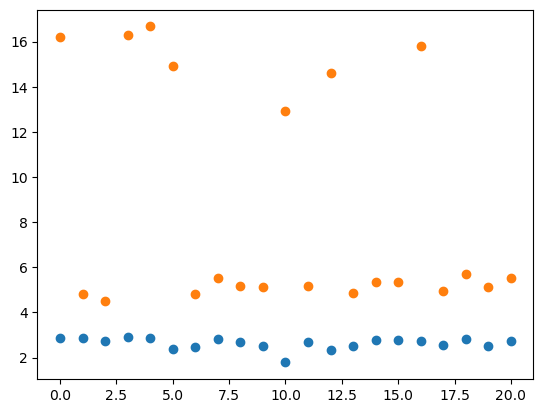

In [18]:
samplechainD = featuredf[featuredf['fileID'].str.contains("Donner_g_ch1")]
plt.plot(samplechainD['generation_number'], samplechainD['total_body_entropy2Daggregated'], marker='o', linestyle='')
plt.plot(samplechainD['generation_number'], samplechainD['total_body_entropy2D'], marker='o', linestyle='')



# Saves the df to the feature extraction file

In [19]:
globals()["feature_extraction"] = featuredf
globals()["feature_extraction"].to_csv(os.path.join(curfolder, f'{"feature_extraction_with2d"}.csv'), index=False)